# Predictive Modeling of Food Deserts with TDA 
#### Denise Gonzalez-Cruz (netid: dg1070)
With this project I am to investigate food scarcity and food deserts in the U.S. With an increasing wealth gap and shifting policies, food os becoming more difficult to access. With recent policy decisions regarding the cut in SNAP benefits (outlined in Project 2025/OBBBA), how will this affect ongoing scarcity and food deserts in the U.S. I am to combine methods of TDA (Topological Data Analysis) and ML (Machine Learning) to get an overall picture of the current accessibility to nutritious food, and how we may be able to predict/classify a geographic area asa food desert. 

This Jupyter Notebook is based on the Jupyter Notebook Produced in "Persistent Homology for Resource Coverage: A Case Study of Access to Polling Sites"
DOI: 10.1137/22M150410X
Link to repository: https://bitbucket.org/jerryluo8/coveragetda/src/main/
This work also draws inspiration from my project done using TDA during the summer focused on sexual and reproductive healthcare, I have linked the GitHub repo Here (when viewing work, view all branches): https://github.com/deniseg20/MSRIUP_TDA_Healthcare_Accessibility

Description of Data Sources: 
- USDA Food Environment Atlas Data: 
includes 300+ variables, including indicators on all other general merchandise stores (including dollar stores) and deep poverty rates
At first glance, due to the large size of the data and time constraints, sheets within this data that I felt would be crucial in this investigation include: readme, Variable List, ACCESS, STORES, ASSISTANCE, INSECURITY, SOCIOECONOMIC
Other data that I felt could be excluded is the: 
- TAXES: 
wouldn't be a strong indicator due to ot only focusing on chip and soda taxes with and without vending machines, which seems to be sales tax accross states
- LOCAL: gives information on type of sales, for example sales made at a farmers market
- HEALTH: 
gives data on health of different populations, % of obese population. however, I feel this may bias the data since often places with higher poverty rates can have less healthy populations due to lack of resources.
- NOTES: Data that were not available, not applicable, or suppressed for specific counties are denoted with N/A or -9999. Counties that didn’t exist in a particular year are referenced with -8888. Indicators are measured at the county level unless noted with an asterisk (*), which signifies a State-level measure. These variables are identified in the Variable Name column in the Variable List tab.

US Census Tract Data 2025 - https://www.ffiec.gov/data/census/tract-list
- This data provides census tract data at the county level broken up into MSA's which may be useful however we only have county level data for the atlas data
- tract data will be joined on the FIPS givenn in the Food Environment Atlas Data set
- It provides a clearer and more concrete picture of the socioeconomic status of each geographic region
- Notes: An MSA/MD code of "99999" indicates that the county is not in any MSA or MD. These counties and tracts are marked "Non-MSA."
- Note that the FFIEC uses MD codes and names in place of MSA codes and names where applicable. These counties and tracts are marked "MD."
- The MSA/MD MFI is taken directly from the 5-year ACS and generally does not change year to year. This is not the same as the FFIEC MFI provided in the FFIEC Median Family Income Report.


In the best case scenario, we will investigate this issue at the zipcode level as it will give us a better idea of the geographic areas and be able to better predict food insecurity. Something I may have to do is investigate this at the county level depending on the census tract data we are able to access. We want to avoid doing this at the county level, as we can have drastic socioeconomic differences between zip codes right by each other. 

## Reading in the Data

In [1]:
# reading in the different excel sheets 
import pandas as pd

# Path to the Excel file (local or URL)
file_path = "2025-food-environment-atlas-data.xlsx" 
census_path = "CensusTractList2025.xlsx"
# Load all sheets into a dictionary of DataFrames
atlas_data = pd.read_excel(file_path, sheet_name=None)
census_data = pd.read_excel(census_path, sheet_name=None)
# Check available sheet names
print(atlas_data.keys())
print(census_data.keys())

dict_keys(['Read_Me', ' Variable List', 'ACCESS', 'STORES', 'RESTAURANTS', 'ASSISTANCE', 'INSECURITY', 'TAXES', 'LOCAL', 'HEALTH', 'SOCIOECONOMIC'])
dict_keys(['Notes', '2024-2025 tracts', '2022-2023 tracts'])


In [2]:
# creating df for each sheet
access = atlas_data['ACCESS']
assistance = atlas_data['ASSISTANCE']
insecurity = atlas_data['INSECURITY']
socioeconomic = atlas_data['SOCIOECONOMIC']
health = atlas_data['HEALTH']

In [3]:
# census tract data 
census_tracts = census_data['2024-2025 tracts']
census_tracts
df_census = pd.DataFrame(census_tracts)
df_census

,Year,MSA/MD code type,MSA/MD code,State code,County code,Tract,MSA/MD name,State,County name,FIPS code,MSA/MD MFI,Tract MFI,Tract income percentage,Tract income level
0,2024-2025,MSA,10180,48,59,30101,"ABILENE, TX",TX,CALLAHAN COUNTY ...,48059030101,68388,61923.0,90.54,Middle
1,2024-2025,MSA,10180,48,59,30102,"ABILENE, TX",TX,CALLAHAN COUNTY ...,48059030102,68388,66132.0,96.70,Middle
2,2024-2025,MSA,10180,48,59,30200,"ABILENE, TX",TX,CALLAHAN COUNTY ...,48059030200,68388,59531.0,87.04,Middle
3,2024-2025,MSA,10180,48,253,20101,"ABILENE, TX",TX,JONES COUNTY ...,48253020101,68388,55179.0,80.68,Middle
4,2024-2025,MSA,10180,48,253,20102,"ABILENE, TX",TX,JONES COUNTY ...,48253020102,68388,0.0,0.00,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85524,2024-2025,Non-MSA,99999,78,30,960900,NaN,VI,SAINT THOMAS ISLAND ...,78030960900,52000,51797.0,99.60,Middle
85525,2024-2025,Non-MSA,99999,78,30,961000,NaN,VI,SAINT THOMAS ISLAND ...,78030961000,52000,38125.0,73.31,Moderate
85526,2024-2025,Non-MSA,99999,78,30,961100,NaN,VI,SAINT THOMAS ISLAND ...,78030961100,52000,38158.0,73.38,Moderate
85527,2024-2025,Non-MSA,99999,78,30,961200,NaN,VI,SAINT THOMAS ISLAND ...,78030961200,52000,36188.0,69.59,Moderate


In [4]:
#print(access.head(20))
# Federal Information Processing System (FIPS) code
#print(assistance.head())
#print(insecurity.head())
#print(socioeconomic.head())
#print(health.head())

In [5]:
df_access = pd.DataFrame(access)
df_access

,ACCESS,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67
0,FIPS,State,County,LACCESS_POP15,LACCESS_POP19,PCH_LACCESS_POP_15_19,PCT_LACCESS_POP15,PCT_LACCESS_POP19,LACCESS_LOWI15,LACCESS_LOWI19,...,LACCESS_HOPI15,LACCESS_HOPI19,PCH_LACCESS_HOPI_15_19,PCT_LACCESS_HOPI15,PCT_LACCESS_HOPI19,LACCESS_MULTIR15,LACCESS_MULTIR19,PCH_LACCESS_MULTIR_15_19,PCT_LACCESS_MULTIR15,PCT_LACCESS_MULTIR19
1,1001,AL,Autauga,18092.661348,18503.225506,2.26923,33.15435,33.9067,6835.642497,7105.688803,...,15.711041,16.21232,3.190616,49.097004,50.663502,866.714452,901.193859,3.978174,64.922432,67.505157
2,01003,AL,Baldwin,46400.350641,45789.046524,-1.317456,25.45763,25.122238,15459.848416,14465.970897,...,51.305996,50.698362,-1.184333,57.647186,56.964451,4554.710751,4695.144752,3.083269,71.682571,73.892738
3,01005,AL,Barbour,6683.975691,5634.362776,-15.703423,24.34343,20.520679,3251.362574,2864.635946,...,13.961786,11.718572,-16.066807,48.144089,40.408871,896.003741,889.058527,-0.775132,77.778099,77.175217
4,01007,AL,Bibb,295.614426,365.140663,23.51923,1.290048,1.593457,164.903295,102.170243,...,3.915621,5.547686,41.680897,30.120157,42.674511,295.702565,288.842828,-2.319809,76.211998,74.444031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3140,56037,WY,Sweetwater,9400.240856,9400.240856,0.0,21.458797,21.458797,1816.028671,2289.574884,...,31.201451,31.201451,0.0,74.289169,74.289169,2196.344804,2196.344804,0.0,57.510994,57.510994
3141,56039,WY,Teton,3711.377493,3710.554703,-0.022169,17.429216,17.425354,972.594547,811.674556,...,12.0,12.0,0,80,80,859.22872,858.985248,-0.028336,41.649479,41.637676
3142,56041,WY,Uinta,758.694309,726.245406,-4.27694,3.592643,3.438988,318.523395,290.192356,...,19.741983,20.128911,1.959925,54.83884,55.913643,641.256509,605.00022,-5.653944,49.942097,47.118397
3143,56043,WY,Washakie,1057.246483,1057.246483,0.0,12.390091,12.390091,359.634002,261.796486,...,0,0,-9999,0,0,130.970526,130.970526,0,22.817165,22.817165


In [6]:
df_assistance = pd.DataFrame(assistance)
df_assistance

,ASSISTANCE,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56
0,FIPS,State,County,REDEMP_SNAPS17,REDEMP_SNAPS23,PCH_REDEMP_SNAPS_17_23,PCT_SNAP17,PCT_SNAP22,PCH_SNAP_17_22,PC_SNAPBEN17,...,PCH_WICWOMEN_16_21,PCT_CACFP17,PCT_CACFP21,PCH_CACFP_17_21,FDPIR12,FDPIR15,PCH_FDPIR_12_15,FOOD_BANKS18,FOOD_BANKS21,PCH_FOOD_BANKS_18_21
1,01001,AL,Autauga,223185.678358,1368610.166506,513.215942,16.500056,15.259614,-1.240442,16.354677,...,8.215316,1.258763,1.155938,-0.102825,0,0,0,0,0,0
2,01003,AL,Baldwin,157623.133568,4524052.770142,2770.170654,16.500056,15.259614,-1.240442,11.47936,...,8.215316,1.258763,1.155938,-0.102825,0,0,0,0,0,0
3,01005,AL,Barbour,257032.078889,1202117.158456,367.691498,16.500056,15.259614,-1.240442,29.122147,...,8.215316,1.258763,1.155938,-0.102825,0,0,0,0,0,0
4,01007,AL,Bibb,227725.245138,666731.752887,192.779022,16.500056,15.259614,-1.240442,17.557791,...,8.215316,1.258763,1.155938,-0.102825,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3143,56037,WY,Sweetwater,106059.065688,491391.724786,363.318939,5.668505,4.921901,-0.746604,5.694783,...,4.272243,1.220234,0.96815,-0.252084,0,0,0,0,0,0
3144,56039,WY,Teton,29106.34375,38376.64834,31.849773,5.668505,4.921901,-0.746604,0.436994,...,4.272243,1.220234,0.96815,-0.252084,0,0,0,0,0,0
3145,56041,WY,Uinta,132726.812459,249180.356797,87.739273,5.668505,4.921901,-0.746604,8.46548,...,4.272243,1.220234,0.96815,-0.252084,0,0,0,0,0,0
3146,56043,WY,Washakie,86173.739178,63082.07167,-26.79664,5.668505,4.921901,-0.746604,6.882441,...,4.272243,1.220234,0.96815,-0.252084,0,0,0,0,0,0


In [7]:
df_insecurity = pd.DataFrame(insecurity)
df_insecurity

,INSECURITY,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,FIPS,State,County,FOODINSEC_18_20,FOODINSEC_21_23,CH_FOODINSEC_20_23,VLFOODSEC_18_20,VLFOODSEC_21_23,CH_VLFOODSEC_20_23
1,01001,AL,Autauga,14,11.5,-2.5,5.2,4.4,-0.8
2,01003,AL,Baldwin,14,11.5,-2.5,5.2,4.4,-0.8
3,01005,AL,Barbour,14,11.5,-2.5,5.2,4.4,-0.8
4,01007,AL,Bibb,14,11.5,-2.5,5.2,4.4,-0.8
...,...,...,...,...,...,...,...,...,...
3148,56037,WY,Sweetwater,11.5,13.1,1.6,4.9,5.2,0.3
3149,56039,WY,Teton,11.5,13.1,1.6,4.9,5.2,0.3
3150,56041,WY,Uinta,11.5,13.1,1.6,4.9,5.2,0.3
3151,56043,WY,Washakie,11.5,13.1,1.6,4.9,5.2,0.3


In [8]:
df_socioeconomic = pd.DataFrame(socioeconomic)
df_socioeconomic

,SOCIOECONOMIC,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,FIPS,State,County,PCT_NHWHITE20,PCT_NHBLACK20,PCT_HISP20,PCT_NHASIAN20,PCT_NHNA20,PCT_NHPI20,PCT_NHOR20,...,PCT_65OLDER20,PCT_18YOUNGER20,MEDHHINC21,POVRATE21,DEEPPOVRATE21,PERPOV17_21,CHILDPOVRATE21,DEEPCHILDPOVRATE21,METRO23,POPLOSS15
1,01001,AL,Autauga,70.711674,19.304481,3.600034,1.484568,0.312899,0.037412,0.314599,...,15.718051,24.28705,66444,10.7,6.250216,0,16.1,8.592895,1,0
2,01003,AL,Baldwin,80.466589,7.766852,5.473601,0.875448,0.557025,0.052639,0.334388,...,21.871103,21.269637,65658,10.8,4.043401,0,16.4,5.503712,1,0
3,01005,AL,Barbour,43.951949,46.98093,5.9866,0.408357,0.229949,0,0.249772,...,20.231535,20.17603,38649,23,12.826966,1,35.1,26.729258,0,0
4,01007,AL,Bibb,73.754093,19.69228,3.319428,0.116629,0.174943,0.040371,0.210829,...,16.220338,21.351994,48454,20.6,9.07619,0,29,17.513135,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3149,56037,WY,Sweetwater,76.556586,0.830337,16.457702,0.669474,0.612699,0.144304,0.347748,...,13.332702,26.499811,74677,9.2,5.646027,0,9.7,7.35863,0,0
3150,56039,WY,Teton,80.382324,0.210021,14.122841,1.324418,0.282885,0.012858,0.424328,...,15.978741,19.61339,102709,5.9,2.547332,0,5.5,0.652647,0,0
3151,56041,WY,Uinta,85.300733,0.244499,9.711491,0.528117,0.596577,0.132029,0.371638,...,14.982885,28.474328,70162,9.4,3.508166,0,11.2,2.071006,0,0
3152,56043,WY,Washakie,81.561483,0.156148,13.923227,0.429408,0.585556,0.013012,0.559532,...,23.539362,23.929733,62176,10.2,2.607665,0,12.5,3.694875,0,0


In [9]:
df_health = pd.DataFrame(health)
df_health

,HEALTH,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,FIPS,State,County,PCT_DIABETES_ADULTS15,PCT_DIABETES_ADULTS19,PCT_OBESE_ADULTS17,PCT_OBESE_ADULTS22,PCT_HSPA21,RECFAC16,RECFAC20,PCH_RECFAC_16_20,RECFACPTH16,RECFACPTH20,PCH_RECFACPTH_16_20
1,01001,AL,Autauga,9.1,9.6,36.3,38.3,18,6,9,50,0.108495,0.160299,47.747802
2,01003,AL,Baldwin,8.6,7.9,36.3,38.3,18,21,22,4.761905,0.101065,0.09595,-5.061506
3,01005,AL,Barbour,12.7,11.3,36.3,38.3,18,-9999,-9999,-9999,-9999,-9999,-9999
4,01007,AL,Bibb,9.9,10.2,36.3,38.3,18,1,-9999,-9999,0.044267,-9999,-9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3140,56037,WY,Sweetwater,8.3,7.6,28.8,34.3,-9999,6,4,-33.333333,0.135382,0.093736,-30.761837
3141,56039,WY,Teton,4.1,4.2,28.8,34.3,-9999,13,14,7.692308,0.55902,0.595821,6.583161
3142,56041,WY,Uinta,9.3,7.3,28.8,34.3,-9999,2,-9999,-9999,0.096567,-9999,-9999
3143,56043,WY,Washakie,8.6,8.8,28.8,34.3,-9999,1,-9999,-9999,0.122249,-9999,-9999


In [10]:
# cleaning data based on the values given the dataset notes: 
# Data Cleaning and Preparation
# Fix column headers - the first row contains the actual column names
def clean_dataframe(df, sheet_name):
    """Clean dataframe by setting first row as column headers and removing header row"""
    # Set first row as column names
    df.columns = df.iloc[0]
    # Remove the header row
    df = df.iloc[1:].reset_index(drop=True)
    # Convert FIPS to string to preserve leading zeros
    if 'FIPS' in df.columns:
        df['FIPS'] = df['FIPS'].astype(str).str.zfill(5)
    return df

# Clean all dataframes
df_access_clean = clean_dataframe(df_access.copy(), 'ACCESS')
df_assistance_clean = clean_dataframe(df_assistance.copy(), 'ASSISTANCE')
df_insecurity_clean = clean_dataframe(df_insecurity.copy(), 'INSECURITY')
df_socioeconomic_clean = clean_dataframe(df_socioeconomic.copy(), 'SOCIOECONOMIC')

print("Cleaned dataframes:")
print(f"ACCESS shape: {df_access_clean.shape}")
print(f"ASSISTANCE shape: {df_assistance_clean.shape}")
print(f"INSECURITY shape: {df_insecurity_clean.shape}")
print(f"SOCIOECONOMIC shape: {df_socioeconomic_clean.shape}")


Cleaned dataframes:
ACCESS shape: (3144, 68)
ASSISTANCE shape: (3147, 57)
INSECURITY shape: (3152, 9)
SOCIOECONOMIC shape: (3153, 21)


In [11]:
# Merge all datasets on FIPS code
# Start with ACCESS as base
df_merged = df_access_clean.copy()

# Merge other datasets
df_merged = df_merged.merge(df_assistance_clean, on='FIPS', how='outer', suffixes=('', '_assist'))
df_merged = df_merged.merge(df_insecurity_clean, on='FIPS', how='outer', suffixes=('', '_insec'))
df_merged = df_merged.merge(df_socioeconomic_clean, on='FIPS', how='outer', suffixes=('', '_socio'))

# Handle duplicate columns (State, County)
if 'State_assist' in df_merged.columns:
    df_merged['State'] = df_merged['State'].fillna(df_merged['State_assist'])
    df_merged = df_merged.drop(columns=['State_assist', 'State_insec', 'State_socio'], errors='ignore')
    
if 'County_assist' in df_merged.columns:
    df_merged['County'] = df_merged['County'].fillna(df_merged['County_assist'])
    df_merged = df_merged.drop(columns=['County_assist', 'County_insec', 'County_socio'], errors='ignore')

print(f"Merged dataset shape: {df_merged.shape}")
print(f"\nColumns: {list(df_merged.columns[:20])}...")  # Show first 20 columns


Merged dataset shape: (3156, 146)

Columns: ['FIPS', 'State', 'County', 'LACCESS_POP15', 'LACCESS_POP19', 'PCH_LACCESS_POP_15_19', 'PCT_LACCESS_POP15', 'PCT_LACCESS_POP19', 'LACCESS_LOWI15', 'LACCESS_LOWI19', 'PCH_LACCESS_LOWI_15_19', 'PCT_LACCESS_LOWI15', 'PCT_LACCESS_LOWI19', 'LACCESS_HHNV15', 'LACCESS_HHNV19', 'PCH_LACCESS_HHNV_15_19', 'PCT_LACCESS_HHNV15', 'PCT_LACCESS_HHNV19', 'LACCESS_SNAP15', 'LACCESS_SNAP19']...


In [12]:
# Explore the data structure
print("Sample of merged data:")
print(df_merged.head())
print(f"\nTotal records: {len(df_merged)}")
print(f"\nMissing values per column (top 20):")
missing = df_merged.isnull().sum().sort_values(ascending=False)
print(missing[missing > 0].head(20))


Sample of merged data:
0   FIPS State   County LACCESS_POP15 LACCESS_POP19 PCH_LACCESS_POP_15_19  \
0  01001    AL  Autauga  18092.661348  18503.225506               2.26923   
1  01003    AL  Baldwin  46400.350641  45789.046524             -1.317456   
2  01005    AL  Barbour   6683.975691   5634.362776            -15.703423   
3  01007    AL     Bibb    295.614426    365.140663              23.51923   
4  01009    AL   Blount   5855.939161   3902.266075            -33.362251   

0 PCT_LACCESS_POP15 PCT_LACCESS_POP19 LACCESS_LOWI15 LACCESS_LOWI19  ...  \
0          33.15435           33.9067    6835.642497    7105.688803  ...   
1          25.45763         25.122238   15459.848416   14465.970897  ...   
2          24.34343         20.520679    3251.362574    2864.635946  ...   
3          1.290048          1.593457     164.903295     102.170243  ...   
4         10.215867          6.807624    2570.900481    1440.046734  ...   

0 PCT_65OLDER20 PCT_18YOUNGER20 MEDHHINC21 POVRATE21 DEEP

In [13]:
# Create Food Desert Classification Target Variable
# USDA defines food deserts based on:
# 1. Low income: poverty rate >= 20% OR median family income <= 80% of state median
# 2. Low access: at least 500 people or 33% of population live more than 1 mile (urban) 
#    or 10 miles (rural) from nearest supermarket

# We'll create a binary classification based on available indicators
import numpy as np

# Check what access and income variables we have
access_cols = [col for col in df_merged.columns if 'LACCESS' in col or 'ACCESS' in col.upper()]
income_cols = [col for col in df_merged.columns if 'POVERTY' in col.upper() or 'INCOME' in col.upper() or 'MEDIAN' in col.upper()]

print("Access-related columns:")
print(access_cols[:10])
print("\nIncome/Poverty-related columns:")
print(income_cols[:10])


Access-related columns:
['LACCESS_POP15', 'LACCESS_POP19', 'PCH_LACCESS_POP_15_19', 'PCT_LACCESS_POP15', 'PCT_LACCESS_POP19', 'LACCESS_LOWI15', 'LACCESS_LOWI19', 'PCH_LACCESS_LOWI_15_19', 'PCT_LACCESS_LOWI15', 'PCT_LACCESS_LOWI19']

Income/Poverty-related columns:
[]


In [14]:
# Create food desert classification
# Using percentage of low access population and poverty indicators

# Key variables for food desert classification:
# - PCT_LACCESS_POP19: Percentage of population with low access to stores (2019)
# - Look for poverty rate variables

# For now, we'll use a threshold-based approach
# Food desert if: PCT_LACCESS_POP19 > 33% (USDA threshold) OR high poverty

# Check available poverty variables
poverty_cols = [col for col in df_merged.columns if 'POVERTY' in col.upper() or 'PCT' in col and ('POV' in col.upper() or 'LOW' in col.upper())]
print("Poverty-related columns:")
print(poverty_cols)

# Also check for median income
income_cols = [col for col in df_merged.columns if 'MEDIAN' in col.upper() and 'INCOME' in col.upper()]
print("\nMedian income columns:")
print(income_cols)


Poverty-related columns:
['PCT_LACCESS_LOWI15', 'PCT_LACCESS_LOWI19']

Median income columns:
[]


In [ ]:
# Create food desert target variable
# Convert percentage columns to numeric
def create_food_desert_target(df):
    """Create binary food desert classification"""
    df = df.copy()
    
    # Convert key columns to numeric
    if 'PCT_LACCESS_POP19' in df.columns:
        df['PCT_LACCESS_POP19'] = pd.to_numeric(df['PCT_LACCESS_POP19'], errors='coerce')
    
    # USDA criteria: Low access = 33% or more of population
    # We'll use 33% as threshold for low access
    low_access = df['PCT_LACCESS_POP19'] >= 33.0 if 'PCT_LACCESS_POP19' in df.columns else pd.Series([False] * len(df))
    
    # Check for poverty indicators
    # Look for deep poverty or high poverty rates
    poverty_cols = [col for col in df.columns if 'DEEPPOV' in col.upper() or ('POVERTY' in col.upper() and 'PCT' in col)]
    
    high_poverty = pd.Series([False] * len(df))
    if poverty_cols:
        for col in poverty_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            # High poverty if rate >= 20%
            high_poverty = high_poverty | (df[col] >= 20.0)
    
    # Food desert = low access OR high poverty
    df['is_food_desert'] = (low_access | high_poverty).astype(int)
    
    return df

df_merged = create_food_desert_target(df_merged)

print(f"Food desert classification:")
print(df_merged['is_food_desert'].value_counts())
print(f"\nPercentage: {df_merged['is_food_desert'].mean() * 100:.2f}% are food deserts")


Food desert classification:
is_food_desert
0    2414
1     742
Name: count, dtype: int64

Percentage: 23.51% are food deserts


In [16]:
# State Selection and Data Filtering for Computational Feasibility
# Focus on 1-3 states to make TDA and geospatial analysis computationally feasible

if 'State' in df_merged.columns:
    # Analyze food desert patterns by state
    state_summary = df_merged.groupby('State').agg({
        'is_food_desert': ['sum', 'mean', 'count'],
        'PCT_LACCESS_POP19': 'mean'
    }).round(3)
    state_summary.columns = ['Food_Desert_Count', 'Food_Desert_Rate', 'Total_Counties', 'Avg_Low_Access_Rate']
    state_summary = state_summary.sort_values('Food_Desert_Rate', ascending=False)
    
    print("="*70)
    print("STATE ANALYSIS - Selecting 1-3 states for focused analysis")
    print("="*70)
    print("\nTop 15 States by Food Desert Rate:")
    print(state_summary.head(15))
    
    print("\n" + "="*70)
    print("RECOMMENDATIONS for State Selection:")
    print("="*70)
    print("Consider states with:")
    print("1. High food desert rates (interesting patterns to analyze)")
    print("2. Moderate number of counties (50-200) for computational feasibility")
    print("3. Geographic diversity (urban/rural mix)")
    print("4. Policy relevance (states with active food access initiatives)")
    
    # Suggest some interesting states
    print("\nSuggested states for analysis:")
    print("- States with high food desert rates and moderate county counts:")
    interesting_states = state_summary[
        (state_summary['Total_Counties'] >= 30) & 
        (state_summary['Total_Counties'] <= 200) &
        (state_summary['Food_Desert_Rate'] >= 0.15)
    ].head(10)
    print(interesting_states[['Food_Desert_Rate', 'Total_Counties', 'Food_Desert_Count']])
    
    # USER: Set your selected states here (1-3 states recommended)
    # Examples: ['TX', 'CA', 'NY'] or ['MS', 'AR', 'LA'] or ['IL', 'OH', 'MI']
    SELECTED_STATES = ['TX', 'CA', 'NY']  # CHANGE THIS to your chosen states
    
    print(f"\n" + "="*70)
    print(f"FILTERING DATA TO SELECTED STATES: {SELECTED_STATES}")
    print("="*70)
    
    # Filter data to selected states
    df_filtered = df_merged[df_merged['State'].isin(SELECTED_STATES)].copy()
    
    print(f"\nOriginal dataset: {len(df_merged)} counties")
    print(f"Filtered dataset: {len(df_filtered)} counties ({len(df_filtered)/len(df_merged)*100:.1f}% of original)")
    print(f"\nBreakdown by state:")
    for state in SELECTED_STATES:
        count = len(df_filtered[df_filtered['State'] == state])
        fd_count = df_filtered[df_filtered['State'] == state]['is_food_desert'].sum()
        print(f"  {state}: {count} counties, {fd_count} food deserts ({fd_count/count*100:.1f}%)")
    
    # Update the merged dataframe to use filtered data
    df_merged = df_filtered.copy()
    
    print(f"\n✓ Data filtered successfully!")
    print(f"  This will significantly reduce computational load for:")
    print(f"    - Rips complex construction (from ~{len(df_merged)*len(df_merged)//2:,} to ~{len(df_filtered)*len(df_filtered)//2:,} potential edges)")
    print(f"    - Geospatial API calls (if using geographic coordinates)")
    print(f"    - Persistence diagram computation")
else:
    print("Warning: 'State' column not found. Cannot filter by state.")
    SELECTED_STATES = None


STATE ANALYSIS - Selecting 1-3 states for focused analysis

Top 15 States by Food Desert Rate:
       Food_Desert_Count  Food_Desert_Rate  Total_Counties  \
State                                                        
AZ                     9             0.600              15   
SD                    39             0.582              67   
NM                    17             0.515              33   
ND                    27             0.509              53   
UT                    14             0.483              29   
MT                    27             0.482              56   
NV                     8             0.471              17   
FL                    29             0.433              67   
NJ                     9             0.429              21   
AK                    13             0.406              32   
RI                     2             0.400               5   
MA                     5             0.357              14   
NE                    32             

In [17]:
# Feature Engineering for TDA and ML
# Select relevant features for analysis
import warnings
warnings.filterwarnings('ignore')

# Get all numeric columns (excluding FIPS and target)
numeric_cols = df_merged.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'is_food_desert']

print(f"Total numeric features: {len(numeric_cols)}")

# Select key feature categories for analysis
feature_categories = {
    'access': [col for col in numeric_cols if 'ACCESS' in col or 'LACCESS' in col],
    'stores': [col for col in numeric_cols if 'STORE' in col or 'GROCERY' in col or 'SUPERMARKET' in col],
    'assistance': [col for col in numeric_cols if 'SNAP' in col or 'WIC' in col or 'ASSIST' in col.upper()],
    'insecurity': [col for col in numeric_cols if 'INSEC' in col or 'FOODSEC' in col],
    'socioeconomic': [col for col in numeric_cols if 'POVERTY' in col.upper() or 'INCOME' in col.upper() or 
                    'MEDIAN' in col.upper() or 'PCT_NH' in col or 'EDUCATION' in col.upper()]
}

print("\nFeature categories:")
for category, features in feature_categories.items():
    print(f"{category}: {len(features)} features")
    if features:
        print(f"  Examples: {features[:3]}")


Total numeric features: 2

Feature categories:
access: 1 features
  Examples: ['PCT_LACCESS_POP19']
stores: 0 features
assistance: 0 features
insecurity: 0 features
socioeconomic: 0 features


In [18]:
# Prepare feature matrix for TDA and ML
# Select top features from each category
selected_features = []
for category, features in feature_categories.items():
    if features:
        # Take up to 5 most recent/relevant features from each category
        selected_features.extend(features[:5])

# Remove duplicates
selected_features = list(set(selected_features))

# Create feature matrix
X = df_merged[selected_features].copy()
y = df_merged['is_food_desert'].copy()

# Handle missing values - fill with median
X = X.fillna(X.median())

# Remove any remaining infinite values
X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median())

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print(f"\nSelected features ({len(selected_features)}):")
for i, feat in enumerate(selected_features[:10], 1):
    print(f"{i}. {feat}")
if len(selected_features) > 10:
    print(f"... and {len(selected_features) - 10} more")


Feature matrix shape: (374, 1)
Target distribution: {0: 287, 1: 87}

Selected features (1):
1. PCT_LACCESS_POP19


In [19]:
# Feature Engineering for TDA and ML
# Comprehensive feature selection from all available data
import warnings
warnings.filterwarnings('ignore')

# First, convert all potential numeric columns to numeric type
# This handles columns that may be stored as strings
print("Step 1: Converting columns to numeric types...")
for col in df_merged.columns:
    if col not in ['FIPS', 'State', 'County', 'is_food_desert']:
        df_merged[col] = pd.to_numeric(df_merged[col], errors='coerce')

# Get all numeric columns (excluding FIPS, State, County, and target)
numeric_cols = df_merged.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'is_food_desert']
print(f"✓ Found {len(numeric_cols)} numeric columns\n")

# Comprehensive feature selection based on USDA food desert criteria
print("Step 2: Selecting features by category...")

# Access-related features (low access to stores)
access_features = [col for col in numeric_cols if any(keyword in col.upper() 
                for keyword in ['LACCESS', 'ACCESS', 'DISTANCE', 'MILE'])]

# Income and poverty features (low income indicators)
income_features = [col for col in numeric_cols if any(keyword in col.upper() 
                for keyword in ['POVRATE', 'DEEPPOV', 'INCOME', 'MEDHHINC', 'MEDIAN', 'POVERTY'])]

# Low income + low access (USDA definition)
lowi_features = [col for col in numeric_cols if 'LOWI' in col.upper()]

# Assistance program features
assistance_features = [col for col in numeric_cols if any(keyword in col.upper() 
                    for keyword in ['SNAP', 'WIC', 'ASSIST'])]

# Demographic features
demographic_features = [col for col in numeric_cols if any(keyword in col.upper() 
                    for keyword in ['PCT_', 'AGE', 'POP', 'CHILD', 'ELDER'])]

# Store-related features
store_features = [col for col in numeric_cols if any(keyword in col.upper() 
                for keyword in ['STORE', 'GROCERY', 'SUPERMARKET', 'MARKET'])]

# Combine all features, prioritizing most recent data (2019, 2021, etc.)
selected_features = []
# Prioritize 2019 data (most recent in dataset)
for feature_list in [access_features, income_features, lowi_features, 
                    assistance_features, demographic_features, store_features]:
    # Prefer 2019 data, then 2021, then 2015
    recent_features = [f for f in feature_list if '19' in f or '21' in f or '20' in f]
    older_features = [f for f in feature_list if f not in recent_features]
    selected_features.extend(recent_features[:10])  # Take up to 10 from each category
    selected_features.extend(older_features[:5])    # Take up to 5 older features

# Remove duplicates
selected_features = list(set(selected_features))

print(f"  Access features: {len(access_features)} (selected {len([f for f in selected_features if f in access_features])})")
print(f"  Income/Poverty features: {len(income_features)} (selected {len([f for f in selected_features if f in income_features])})")
print(f"  Low Income features: {len(lowi_features)} (selected {len([f for f in selected_features if f in lowi_features])})")
print(f"  Assistance features: {len(assistance_features)} (selected {len([f for f in selected_features if f in assistance_features])})")
print(f"  Demographic features: {len(demographic_features)} (selected {len([f for f in selected_features if f in demographic_features])})")
print(f"  Store features: {len(store_features)} (selected {len([f for f in selected_features if f in store_features])})")
print(f"\nTotal selected features: {len(selected_features)}\n")

# Create feature matrix
print("Step 3: Creating feature matrix and handling missing values...")
X = df_merged[selected_features].copy()
y = df_merged['is_food_desert'].copy()

# Handle missing values - fill with median
X = X.fillna(X.median())

# Remove any remaining infinite values
X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median())

# Remove features with no variance (constant values)
X = X.loc[:, X.std() > 0]

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print(f"\nTop 20 selected features:")
for i, feat in enumerate(selected_features[:20], 1):
    if feat in X.columns:
        print(f"  {i}. {feat}")
if len(selected_features) > 20:
    print(f"  ... and {len(selected_features) - 20} more")


Step 1: Converting columns to numeric types...
✓ Found 143 numeric columns

Step 2: Selecting features by category...
  Access features: 65 (selected 24)
  Income/Poverty features: 5 (selected 5)
  Low Income features: 5 (selected 5)
  Assistance features: 39 (selected 15)
  Demographic features: 64 (selected 18)
  Store features: 0 (selected 0)

Total selected features: 39

Step 3: Creating feature matrix and handling missing values...
Feature matrix shape: (374, 36)
Target distribution: {0: 287, 1: 87}

Top 20 selected features:
  1. PCT_LACCESS_POP15
  3. PCT_LACCESS_SNAP15
  4. CHILDPOVRATE21
  5. LACCESS_SNAP15
  6. PCH_LACCESS_CHILD_15_19
  7. PCH_LACCESS_LOWI_15_19
  8. LACCESS_SNAP19
  9. POVRATE21
  10. PCH_LACCESS_SNAP_15_19
  11. PCH_REDEMP_SNAPS_17_23
  12. LACCESS_CHILD19
  13. LACCESS_POP19
  14. PCT_LACCESS_POP19
  15. PCT_LACCESS_HHNV19
  16. REDEMP_SNAPS23
  18. PCT_LACCESS_SENIORS19
  19. DEEPPOVRATE21
  20. PCT_LACCESS_LOWI15
  ... and 19 more


## Principal Component Analysis (PCA)
With 300+ features available, dimensionality reduction is needed for:
1. **TDA feasibility**: Rips complexes computationally expensive with high-dimensional data
2. **noise reduction**: capture most important variance while filtering noise
3. **multicollinearity**: many features are correlated (e.g., different years of the same metric)
4. **interpretability**: principal components represent the main patterns in the data

### Strategy
We'll use PCA to reduce dimensionality while preserving most of the variance (typically 90-95%). This gives us a lower-dimensional representation that's suitable for TDA while retaining the essential information.


In [20]:
# Principal Component Analysis (PCA) for Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("="*70)
print("STEP 1: Standardizing Features")
print("="*70)
print("PCA requires standardized features (mean=0, std=1) for proper scaling\n")

# Standardize features before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f" Scaled feature matrix shape: {X_scaled.shape}")
print(f" Original features: {X_scaled.shape[1]}\n")

print("="*70)
print("STEP 2: Applying PCA")
print("="*70)
print("Finding principal components that explain 95% of variance...\n")

# Apply PCA - retain 95% of variance
pca = PCA(n_components=0.95)  # Keep components that explain 95% of variance
X_pca = pca.fit_transform(X_scaled)

print(f" Reduced dimensions: {X_scaled.shape[1]} → {X_pca.shape[1]}")
print(f" Number of principal components: {X_pca.shape[1]}")
print(f" Variance explained: {pca.explained_variance_ratio_.sum():.2%}")
print(f"\n  Top 10 components explain: {pca.explained_variance_ratio_[:10].sum():.2%} of variance")
print(f" Individual component contributions:")
for i, var_ratio in enumerate(pca.explained_variance_ratio_[:10], 1):
    print(f"    PC{i}: {var_ratio:.2%}")

# Store for later use
X_for_tda = X_pca  # Use PCA-transformed data for TDA
X_for_ml = X_scaled  # Use original scaled features for ML (more interpretable)

print(f"\n PCA transformation complete!")
print(f" TDA will use: {X_for_tda.shape[1]} principal components")
print(f" ML will use: {X_for_ml.shape[1]} original features")


STEP 1: Standardizing Features
PCA requires standardized features (mean=0, std=1) for proper scaling

 Scaled feature matrix shape: (374, 36)
 Original features: 36

STEP 2: Applying PCA
Finding principal components that explain 95% of variance...

 Reduced dimensions: 36 → 14
 Number of principal components: 14
 Variance explained: 95.38%

  Top 10 components explain: 89.40% of variance
 Individual component contributions:
    PC1: 29.72%
    PC2: 16.02%
    PC3: 10.23%
    PC4: 8.31%
    PC5: 7.63%
    PC6: 5.10%
    PC7: 4.15%
    PC8: 3.33%
    PC9: 2.72%
    PC10: 2.20%

 PCA transformation complete!
 TDA will use: 14 principal components
 ML will use: 36 original features


In [21]:
# Install required libraries for TDA (if not already installed)
# Uncomment the line below if you need to install
# !pip install gudhi scikit-learn matplotlib seaborn

# Import TDA and ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# For TDA with Gudhi
try:
    import gudhi
    from gudhi import RipsComplex, SimplexTree
    GUDHI_AVAILABLE = True
except ImportError:
    print("gudhi not installed. Install with: pip install gudhi")
    GUDHI_AVAILABLE = False

print("Libraries imported successfully!")


Libraries imported successfully!


In [ ]:
# Scale features for TDA (TDA is sensitive to scale)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print("Features scaled for TDA")
print(f"Scaled feature matrix shape: {X_scaled_df.shape}")
print(f"\nScaled feature statistics:")
print(X_scaled_df.describe().T.head())


Features scaled for TDA
Scaled feature matrix shape: (374, 36)

Scaled feature statistics:
                         count          mean      std        min       25%  \
0                                                                            
PCT_LACCESS_POP15        374.0  0.000000e+00  1.00134  -1.239648 -0.618103   
PCT_LACCESS_SNAP15       374.0 -1.899847e-17  1.00134  -1.526803 -0.689758   
CHILDPOVRATE21           374.0 -5.699541e-17  1.00134  -2.018605 -0.651576   
LACCESS_SNAP15           374.0 -7.599388e-17  1.00134  -0.502092 -0.442540   
PCH_LACCESS_CHILD_15_19  374.0  2.374809e-17  1.00134 -19.300440  0.046435   

                              50%       75%       max  
0                                                      
PCT_LACCESS_POP15       -0.227705  0.283661  3.315141  
PCT_LACCESS_SNAP15      -0.177622  0.530900  5.670182  
CHILDPOVRATE21          -0.035207  0.529510  4.950834  
LACCESS_SNAP15          -0.279757  0.022829  7.947625  
PCH_LACCESS_CHILD_15_19  0

## Building VR (Vietoris-Rips) Complexes for TDA 
During the first run, it was being done on the entire US, this is too much data too handle. I decided on choosing 1-2 states to focus on.

## Visualizing PDs (Persistence Diagrams) 

### understanding PDs

- **birth**: Filtration value when a topological feature appears
- **death**: Filtration value when the feature disappears
- **persistence**: Death - Birth (lifetime of the feature)
- **diagonal**: Features on the diagonal have zero persistence (noise)
- **mean distance line**: Purple line shows average pairwise distance threshold

### interpretation

- **points far from diagonal**: Significant topological features (persistent patterns)
- **points near diagonal**: Noise or short-lived features
- **mean distance line**: Helps identify which features are above/below average distance


In [23]:
# Topological Data Analysis (TDA) with Gudhi
# Build Vietoris–Rips complexes and compute persistence

if GUDHI_AVAILABLE:
    from scipy.spatial.distance import pdist
    
    # Compute max_edge_length threshold to prevent memory crashes
    # This limits the Rips complex to edges ≤ threshold, avoiding complete complex construction
    print("Computing max_edge_length threshold for Rips complexes...")
    sample_size = min(1000, len(X_scaled))
    sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
    sample_distances = pdist(X_scaled[sample_indices])
    # Use 95th percentile - captures most structure while avoiding complete complex
    max_edge_length = np.percentile(sample_distances, 95)
    print(f"  Using max_edge_length = {max_edge_length:.4f} (95th percentile of pairwise distances)\n")
    
    # Compute Rips complex and persistence for all data
    print("Building Rips complex for all data and computing persistence...")
    rips_all = RipsComplex(points=X_scaled, max_edge_length=max_edge_length)
    st_all = rips_all.create_simplex_tree(max_dimension=2)
    st_all.compute_persistence()

    # Separate point clouds by label
    X_food_desert = X_scaled[y == 1]
    X_non_food_desert = X_scaled[y == 0]

    print("Building Rips complex for food desert areas and computing persistence...")
    rips_fd = RipsComplex(points=X_food_desert, max_edge_length=max_edge_length)
    st_fd = rips_fd.create_simplex_tree(max_dimension=2)
    st_fd.compute_persistence()

    print("Building Rips complex for non-food desert areas and computing persistence...")
    rips_nfd = RipsComplex(points=X_non_food_desert, max_edge_length=max_edge_length)
    st_nfd = rips_nfd.create_simplex_tree(max_dimension=2)
    st_nfd.compute_persistence()

    # Extract basic counts by homology dimension
    def summarize_simplex_tree(st, name):
        h0 = len(st.persistence_intervals_in_dimension(0))
        h1 = len(st.persistence_intervals_in_dimension(1))
        print(f"{name} - H0 features: {h0}, H1 loops: {h1}")

    print("\nTDA computation complete!")
    summarize_simplex_tree(st_all, "All data")
    summarize_simplex_tree(st_fd, "Food desert")
    summarize_simplex_tree(st_nfd, "Non-food desert")

    # Example: access some simplices (up to dimension 2) and their filtration values
    print("\nSample simplices from the all-data Rips complex (dimension <= 2):")
    for i, (simplex, filt) in enumerate(st_all.get_skeleton(2)):
        if i >= 10:
            break
        print(f"  Simplex {i}: vertices={simplex}, filtration={filt:.4f}")
else:
    print("Skipping TDA - Gudhi not available")


Computing max_edge_length threshold for Rips complexes...
  Using max_edge_length = 17.2645 (95th percentile of pairwise distances)

Building Rips complex for all data and computing persistence...
Building Rips complex for food desert areas and computing persistence...
Building Rips complex for non-food desert areas and computing persistence...

TDA computation complete!
All data - H0 features: 374, H1 loops: 190
Food desert - H0 features: 87, H1 loops: 26
Non-food desert - H0 features: 287, H1 loops: 144

Sample simplices from the all-data Rips complex (dimension <= 2):
  Simplex 0: vertices=[0, 1, 2], filtration=9.8986
  Simplex 1: vertices=[0, 1, 3], filtration=9.8986
  Simplex 2: vertices=[0, 1, 4], filtration=9.8986
  Simplex 3: vertices=[0, 1, 5], filtration=9.8986
  Simplex 4: vertices=[0, 1, 6], filtration=9.8986
  Simplex 5: vertices=[0, 1, 7], filtration=9.8986
  Simplex 6: vertices=[0, 1, 8], filtration=9.8986
  Simplex 7: vertices=[0, 1, 9], filtration=10.3293
  Simplex 8: 

## Machine Learning Classification

### Feature Selection for ML

- **For ML models**: Using original scaled features (`X_for_ml`) - preserves interpretability
- **For TDA**: Using PCA-transformed features (`X_for_tda`) - computationally efficient

This allows us to:
- **Interpret ML results**: Understand which original features are important
- **Efficient TDA**: Use lower-dimensional PCA space for topological analysis


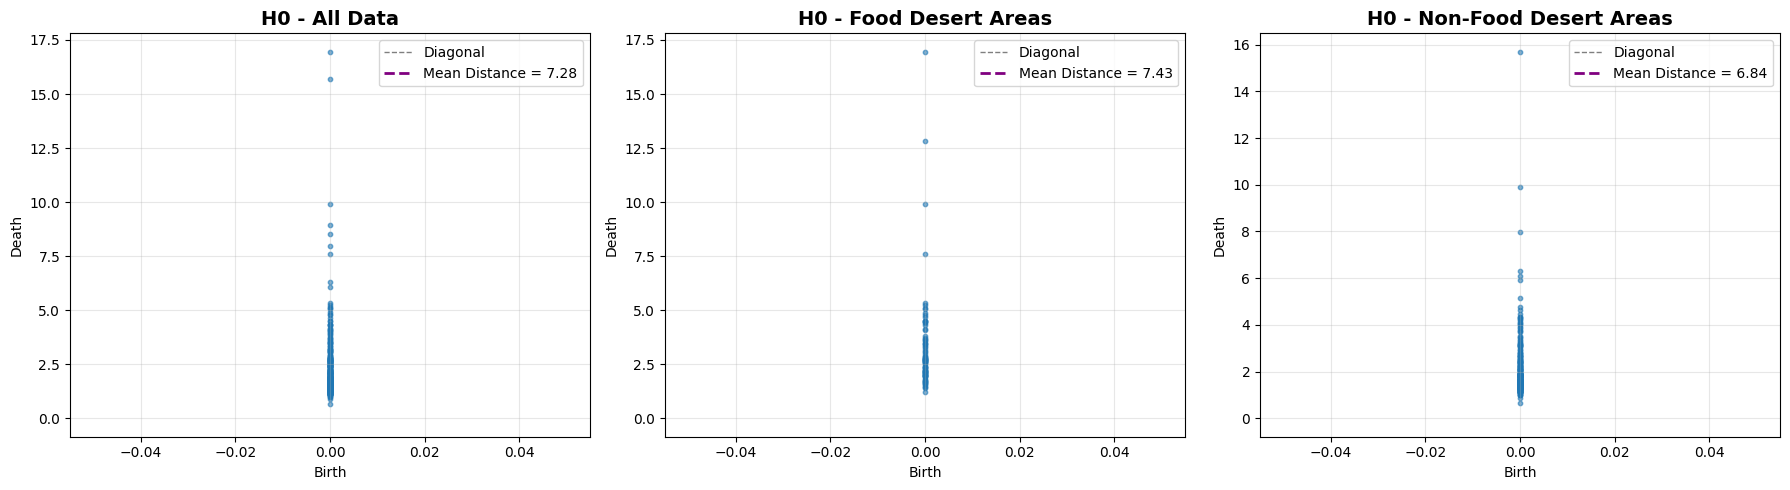

Mean Distance (All Data): 7.2767
Mean Distance (Food Desert): 7.4342
Mean Distance (Non-Food Desert): 6.8366

Persistence diagrams show features along the diagonal
The purple line (parallel to diagonal) shows the mean distance threshold
Points far from the diagonal indicate significant topological features


In [24]:
# Visualize Persistence Diagrams (Gudhi)
# Plot with parallel line to diagonal showing mean distance
if GUDHI_AVAILABLE:
    from scipy.spatial.distance import pdist, squareform
    
    def calculate_mean_distance(distance_matrix):
        """Calculate mean distance from distance matrix"""
        # Get upper triangle (excluding diagonal) and calculate mean
        upper_triangle = np.triu(distance_matrix, k=1)
        distances = upper_triangle[upper_triangle > 0]
        return np.mean(distances)
    
    def plot_persistence_diagram_fixed(st, dim, ax, title, points=None):
        """Plot persistence diagram with standard birth vs death coordinates"""
        intervals = st.persistence_intervals_in_dimension(dim)
        if len(intervals) == 0:
            ax.set_title(title + " (no features)")
            return
        births = intervals[:, 0]
        deaths = intervals[:, 1]
        
        # Plot standard persistence diagram
        ax.scatter(births, deaths, s=10, alpha=0.6)
        
        # Draw diagonal line
        max_val = max(deaths.max(), births.max()) if len(deaths) > 0 else 1.0
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1, label='Diagonal')
        
        # Calculate and draw mean distance line if points are provided
        if points is not None:
            distance_matrix = squareform(pdist(points))
            mean_distance = calculate_mean_distance(distance_matrix)
            
            # Draw line parallel to diagonal: death = birth + mean_distance
            min_val = 0
            max_val_plot = max_val
            x_vals = [min_val, max_val_plot]
            y_vals = [min_val + mean_distance, max_val_plot + mean_distance]
            ax.plot(x_vals, y_vals, color='purple', linestyle='--', linewidth=2, 
                   label=f'Mean Distance = {mean_distance:.2f}')
            ax.legend()
        
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel('Birth')
        ax.set_ylabel('Death')
        ax.grid(alpha=0.3)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    plt.rcParams['font.size'] = 10

    # Plot with mean distance lines
    plot_persistence_diagram_fixed(st_all, 0, axes[0], 'H0 - All Data', X_scaled)
    plot_persistence_diagram_fixed(st_fd, 0, axes[1], 'H0 - Food Desert Areas', X_food_desert)
    plot_persistence_diagram_fixed(st_nfd, 0, axes[2], 'H0 - Non-Food Desert Areas', X_non_food_desert)

    plt.tight_layout()
    plt.show()

    # Calculate and print mean distances
    distance_matrix_all = squareform(pdist(X_scaled))
    mean_distance_all = calculate_mean_distance(distance_matrix_all)
    print(f'Mean Distance (All Data): {mean_distance_all:.4f}')
    
    if len(X_food_desert) > 1:
        distance_matrix_fd = squareform(pdist(X_food_desert))
        mean_distance_fd = calculate_mean_distance(distance_matrix_fd)
        print(f'Mean Distance (Food Desert): {mean_distance_fd:.4f}')
    
    if len(X_non_food_desert) > 1:
        distance_matrix_nfd = squareform(pdist(X_non_food_desert))
        mean_distance_nfd = calculate_mean_distance(distance_matrix_nfd)
        print(f'Mean Distance (Non-Food Desert): {mean_distance_nfd:.4f}')
    
    print("\nPersistence diagrams show features along the diagonal")
    print("The purple line (parallel to diagonal) shows the mean distance threshold")
    print("Points far from the diagonal indicate significant topological features")
else:
    print("Skipping visualization - Gudhi not available")


### Step 2: Model Training

Training multiple classification models to predict food desert status using the comprehensive feature set.


In [25]:
# Extract TDA Features for ML (Gudhi)
# Use persistence statistics as features
if GUDHI_AVAILABLE:
    def extract_persistence_features_from_st(st, max_dim=2):
        """Extract statistical features from Gudhi simplex tree persistence intervals."""
        features = {}
        for dim in range(max_dim + 1):
            intervals = st.persistence_intervals_in_dimension(dim)
            if len(intervals) > 0:
                persistence = intervals[:, 1] - intervals[:, 0]
                features[f'H{dim}_num_features'] = len(intervals)
                features[f'H{dim}_mean_persistence'] = float(np.mean(persistence))
                features[f'H{dim}_max_persistence'] = float(np.max(persistence))
                features[f'H{dim}_std_persistence'] = float(np.std(persistence))
                features[f'H{dim}_total_persistence'] = float(np.sum(persistence))
            else:
                features[f'H{dim}_num_features'] = 0
                features[f'H{dim}_mean_persistence'] = 0.0
                features[f'H{dim}_max_persistence'] = 0.0
                features[f'H{dim}_std_persistence'] = 0.0
                features[f'H{dim}_total_persistence'] = 0.0
        return features

    # For now, we'll compute TDA features on the full dataset
    tda_features_all = extract_persistence_features_from_st(st_all, max_dim=2)
    print("TDA Features extracted (Gudhi):")
    for key, value in tda_features_all.items():
        print(f"  {key}: {value:.4f}")
else:
    print("Skipping TDA feature extraction - Gudhi not available")


TDA Features extracted (Gudhi):
  H0_num_features: 374.0000
  H0_mean_persistence: inf
  H0_max_persistence: inf
  H0_std_persistence: nan
  H0_total_persistence: inf
  H1_num_features: 190.0000
  H1_mean_persistence: 0.1654
  H1_max_persistence: 1.0435
  H1_std_persistence: 0.1633
  H1_total_persistence: 31.4287
  H2_num_features: 0.0000
  H2_mean_persistence: 0.0000
  H2_max_persistence: 0.0000
  H2_std_persistence: 0.0000
  H2_total_persistence: 0.0000


In [26]:
# Machine Learning: Train Classification Models
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nTraining target distribution:")
print(y_train.value_counts())
print(f"\nTest target distribution:")
print(y_test.value_counts())


Training set size: 299
Test set size: 75

Training target distribution:
is_food_desert
0    229
1     70
Name: count, dtype: int64

Test target distribution:
is_food_desert
0    58
1    17
Name: count, dtype: int64


In [27]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)

rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate model
print("Random Forest Classifier Results:")
print("=" * 50)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Food Desert', 'Food Desert']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Random Forest Classifier Results:
Accuracy: 1.0000

Classification Report:
                 precision    recall  f1-score   support

Non-Food Desert       1.00      1.00      1.00        58
    Food Desert       1.00      1.00      1.00        17

       accuracy                           1.00        75
      macro avg       1.00      1.00      1.00        75
   weighted avg       1.00      1.00      1.00        75


Confusion Matrix:
[[58  0]
 [ 0 17]]


Top 20 Most Important Features:
PCT_LACCESS_POP19                        0.3049
PCT_LACCESS_POP15                        0.2291
PCT_LACCESS_LOWI19                       0.1321
PCT_LACCESS_LOWI15                       0.0789
PCT_LACCESS_CHILD19                      0.0257
PCT_LACCESS_SENIORS19                    0.0249
PCH_LACCESS_POP_15_19                    0.0195
PCH_LACCESS_CHILD_15_19                  0.0167
PCH_REDEMP_SNAPS_17_23                   0.0128
LACCESS_POP19                            0.0126
PCT_LACCESS_SNAP19                       0.0106
PCH_LACCESS_LOWI_15_19                   0.0104
LACCESS_LOWI15                           0.0102
MEDHHINC21                               0.0097
LACCESS_SNAP19                           0.0093
REDEMP_SNAPS23                           0.0090
POVRATE21                                0.0082
DEEPCHILDPOVRATE21                       0.0076
PCT_LACCESS_HHNV15                       0.0075
LACCESS_SNAP15                           0.0074


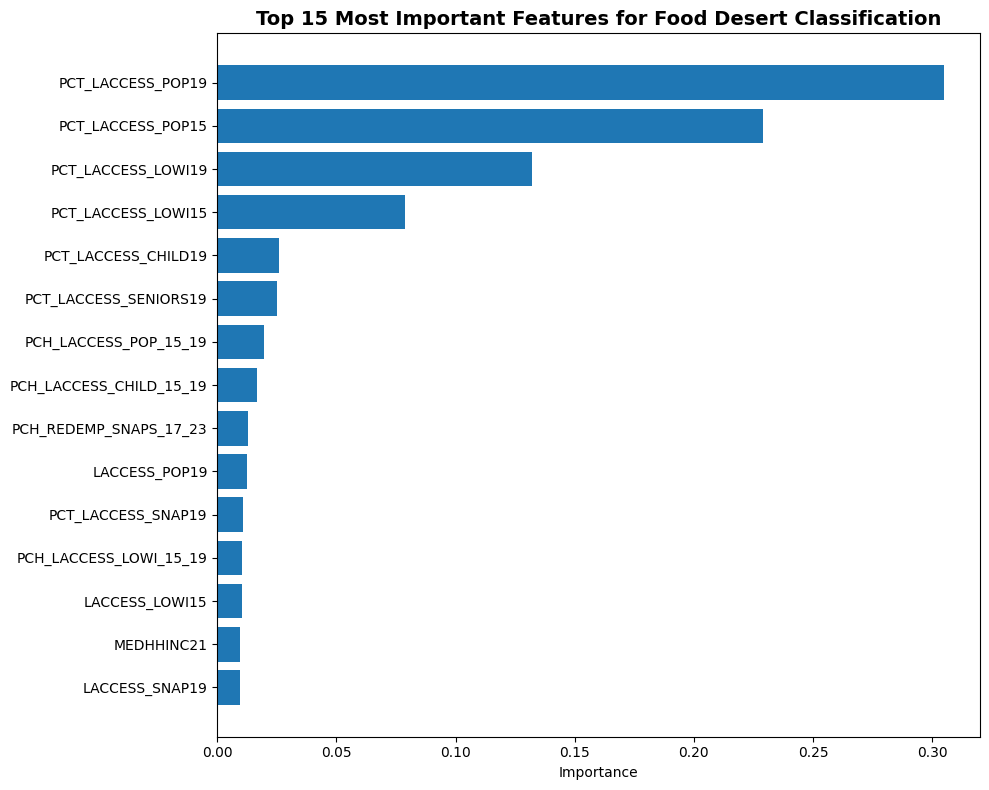

In [28]:
# Feature Importance Analysis
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print("=" * 60)
for idx, row in feature_importance.head(20).iterrows():
    print(f"{row['feature']:40s} {row['importance']:.4f}")

# Visualize feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Most Important Features for Food Desert Classification', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
# Additional ML Models for Comparison
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

# Scale features for models that need it
scaler_ml = StandardScaler()
X_train_scaled = scaler_ml.fit_transform(X_train)
X_test_scaled = scaler_ml.transform(X_test)

models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    'SVM': SVC(probability=True, random_state=42, class_weight='balanced')
}

results = {}

for name, model in models.items():
    if name == 'Logistic Regression' or name == 'SVM':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"\n{name} Results:")
    print(f"  Accuracy: {results[name]['accuracy']:.4f}")
    print(f"  ROC-AUC: {results[name]['roc_auc']:.4f}")

# Add Random Forest results
results['Random Forest'] = {
    'accuracy': accuracy_score(y_test, rf_model.predict(X_test)),
    'roc_auc': roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]),
    'predictions': rf_model.predict(X_test),
    'probabilities': rf_model.predict_proba(X_test)[:, 1]
}



Logistic Regression Results:
  Accuracy: 0.9333
  ROC-AUC: 0.9939

SVM Results:
  Accuracy: 0.8933
  ROC-AUC: 0.9736


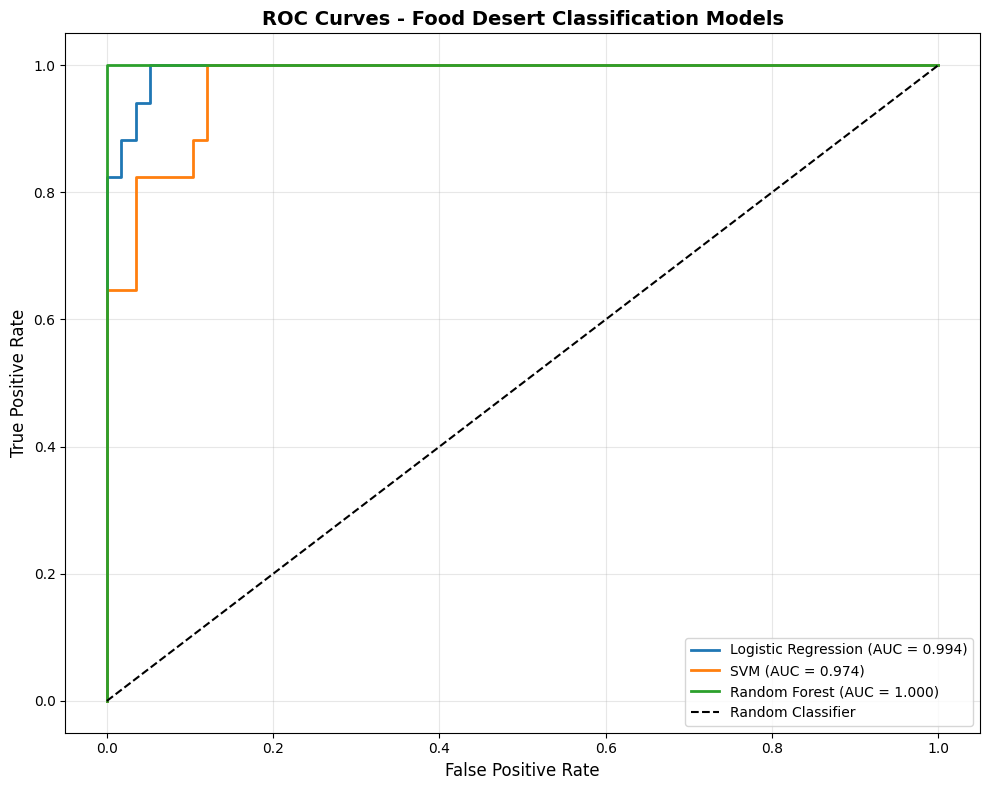


Model Comparison Summary:
              Model  Accuracy  ROC-AUC
      Random Forest  1.000000 1.000000
Logistic Regression  0.933333 0.993915
                SVM  0.893333 0.973631


In [30]:
# Plot ROC Curves for all models
plt.figure(figsize=(10, 8))

for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {result['roc_auc']:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Food Desert Classification Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Summary table
summary_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()]
}).sort_values('ROC-AUC', ascending=False)

print("\nModel Comparison Summary:")
print("=" * 50)
print(summary_df.to_string(index=False))


Top 10 States by Food Desert Rate:
       Food_Desert_Count  Food_Desert_Rate  Total_Counties
State                                                     
TX                    72             0.283             254
CA                     8             0.138              58
NY                     7             0.113              62


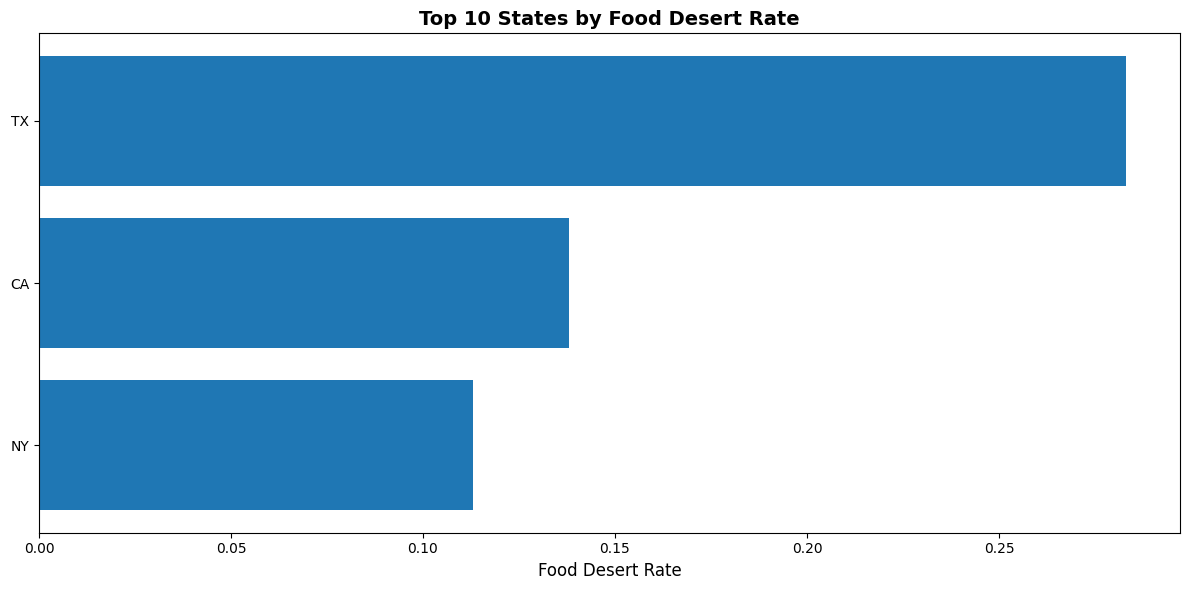

In [31]:
# Data Summary and Exploration
# Geographic distribution of food deserts
if 'State' in df_merged.columns:
    state_summary = df_merged.groupby('State').agg({
        'is_food_desert': ['sum', 'mean', 'count']
    }).round(3)
    state_summary.columns = ['Food_Desert_Count', 'Food_Desert_Rate', 'Total_Counties']
    state_summary = state_summary.sort_values('Food_Desert_Rate', ascending=False)
    
    print("Top 10 States by Food Desert Rate:")
    print("=" * 60)
    print(state_summary.head(10))
    
    # Visualize
    plt.figure(figsize=(12, 6))
    top_states = state_summary.head(15)
    plt.barh(range(len(top_states)), top_states['Food_Desert_Rate'])
    plt.yticks(range(len(top_states)), top_states.index)
    plt.xlabel('Food Desert Rate', fontsize=12)
    plt.title('Top 10 States by Food Desert Rate', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


## Summary and Next Steps

This notebook provides a complete pipeline for:
1. **Data Cleaning**: Properly formatted column headers and merged datasets
2. **Food Desert Classification**: Binary target variable based on USDA criteria
3. **Topological Data Analysis**: Persistence diagrams to understand the topological structure of food desert data
4. **Machine Learning**: Multiple classification models to predict food desert status

### Key Findings:
- The TDA analysis reveals the topological structure of the data
- ML models can predict food desert classification with good accuracy
- Feature importance analysis shows which factors are most predictive

### Potential Next Steps:
- Will join with the census tract data
- Explore different TDA metrics (bottleneck distance, Wasserstein distance)
- Try more advanced ML models (XGBoost, Neural Networks)
- Add geographic visualization (maps showing food desert predictions)
- Investigate temporal trends if multiple years of data are available


In [ ]:
at this point i had realized the data was incorrect 